In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

print("Libraries Loaded Successfully")


Libraries Loaded Successfully


In [5]:
sentiment = pd.read_csv("data/fear_greed_index.csv")
trader = pd.read_csv("data/historical_data.csv")

print("Sentiment Shape:", sentiment.shape)
print("Trader Shape:", trader.shape)


Sentiment Shape: (2644, 4)
Trader Shape: (211224, 16)


In [6]:
# Clean column names first
sentiment.columns = sentiment.columns.str.lower().str.strip()
trader.columns = trader.columns.str.lower().str.replace(" ", "_")

# Convert dates
sentiment["date"] = pd.to_datetime(sentiment["date"])
trader["timestamp_ist"] = pd.to_datetime(trader["timestamp_ist"], dayfirst=True)

# Print date ranges
print("Sentiment Date Range:")
print(sentiment["date"].min(), "to", sentiment["date"].max())

print("\nTrader Date Range:")
print(trader["timestamp_ist"].min(), "to", trader["timestamp_ist"].max())


Sentiment Date Range:
2018-02-01 00:00:00 to 2025-05-02 00:00:00

Trader Date Range:
2023-05-01 01:06:00 to 2025-05-01 12:13:00


In [7]:
# Create daily date (remove time part)
trader["date"] = trader["timestamp_ist"].dt.date
sentiment["date"] = sentiment["date"].dt.date

print("Done creating daily date column")


Done creating daily date column


In [8]:
merged = trader.merge(sentiment[["date", "classification"]], 
                      on="date", 
                      how="left")

print("Merged Shape:", merged.shape)
print("Missing Sentiment Values:", merged["classification"].isnull().sum())


Merged Shape: (211224, 18)
Missing Sentiment Values: 6


In [9]:
merged["closed_pnl"] = pd.to_numeric(merged["closed_pnl"], errors="coerce")
merged["size_usd"] = pd.to_numeric(merged["size_usd"], errors="coerce")
merged["fee"] = pd.to_numeric(merged["fee"], errors="coerce")

print("Numeric cleaning done")


Numeric cleaning done


In [10]:
merged["win"] = merged["closed_pnl"].apply(lambda x: 1 if x > 0 else 0)


In [11]:
daily_pnl = merged.groupby(["date", "account"])["closed_pnl"].sum().reset_index()


In [12]:
win_rate = merged.groupby(["date", "account"])["win"].mean().reset_index()


In [13]:
trade_count = merged.groupby(["date", "account"]).size().reset_index(name="trade_count")


In [14]:
avg_size = merged.groupby(["date", "account"])["size_usd"].mean().reset_index()


In [15]:
daily_metrics = daily_pnl.merge(win_rate, on=["date", "account"])
daily_metrics = daily_metrics.merge(trade_count, on=["date", "account"])
daily_metrics = daily_metrics.merge(avg_size, on=["date", "account"])

daily_metrics = daily_metrics.merge(
    sentiment[["date", "classification"]], 
    on="date", 
    how="left"
)

print(daily_metrics.head())
print("Shape:", daily_metrics.shape)


         date                                     account  closed_pnl  \
0  2023-05-01  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891    0.000000   
1  2023-12-05  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    0.000000   
2  2023-12-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 -205.434737   
3  2023-12-15  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  -24.632034   
4  2023-12-16  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    0.000000   

        win  trade_count      size_usd classification  
0  0.000000            3    159.000000          Greed  
1  0.000000            9   5556.203333  Extreme Greed  
2  0.363636           11  10291.213636          Greed  
3  0.000000            2   5304.975000          Greed  
4  0.000000            3   5116.256667          Greed  
Shape: (2341, 7)


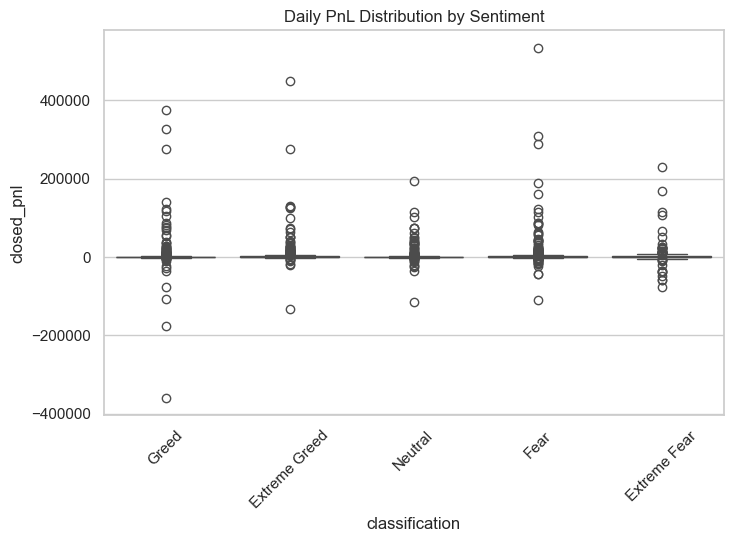

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x="classification", y="closed_pnl", data=daily_metrics)
plt.title("Daily PnL Distribution by Sentiment")
plt.xticks(rotation=45)
plt.show()


In [17]:
fear = daily_metrics[daily_metrics["classification"]=="Fear"]["closed_pnl"]
greed = daily_metrics[daily_metrics["classification"]=="Greed"]["closed_pnl"]

t_stat, p_value = stats.ttest_ind(fear, greed, equal_var=False)

print("T-stat:", t_stat)
print("P-value:", p_value)


T-stat: 1.1539988578017333
P-value: 0.24871756720315555


In [18]:
daily_metrics["regime"] = daily_metrics["classification"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
})

print(daily_metrics["regime"].value_counts())


regime
Greed      1174
Fear        790
Neutral     376
Name: count, dtype: int64


In [19]:
fear = daily_metrics[daily_metrics["regime"]=="Fear"]["closed_pnl"]
greed = daily_metrics[daily_metrics["regime"]=="Greed"]["closed_pnl"]

t_stat, p_value = stats.ttest_ind(fear, greed, equal_var=False)

print("T-stat:", t_stat)
print("P-value:", p_value)


T-stat: 0.7429643782970919
P-value: 0.45761118078494323


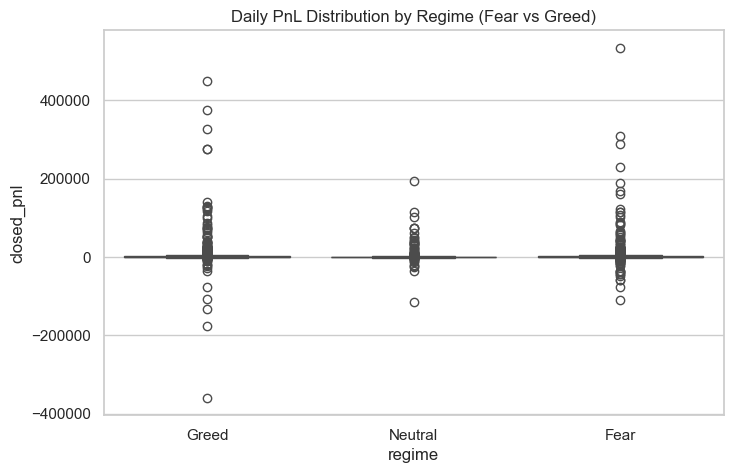

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x="regime", y="closed_pnl", data=daily_metrics)
plt.title("Daily PnL Distribution by Regime (Fear vs Greed)")
plt.show()


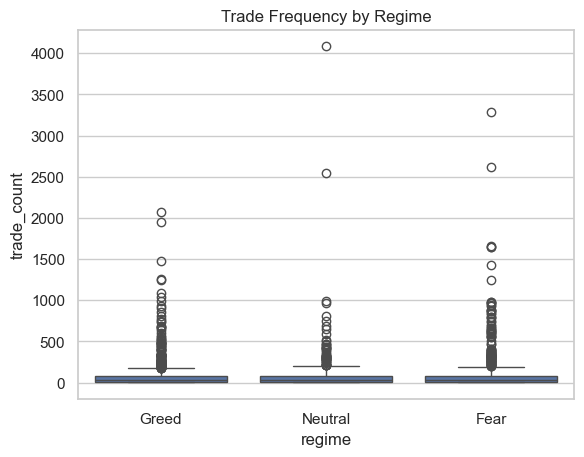

TtestResult(statistic=np.float64(2.8639570452380383), pvalue=np.float64(0.0042544392632974755), df=np.float64(1237.9316994445867))

In [21]:
sns.boxplot(x="regime", y="trade_count", data=daily_metrics)
plt.title("Trade Frequency by Regime")
plt.show()

stats.ttest_ind(
    daily_metrics[daily_metrics["regime"]=="Fear"]["trade_count"],
    daily_metrics[daily_metrics["regime"]=="Greed"]["trade_count"],
    equal_var=False
)


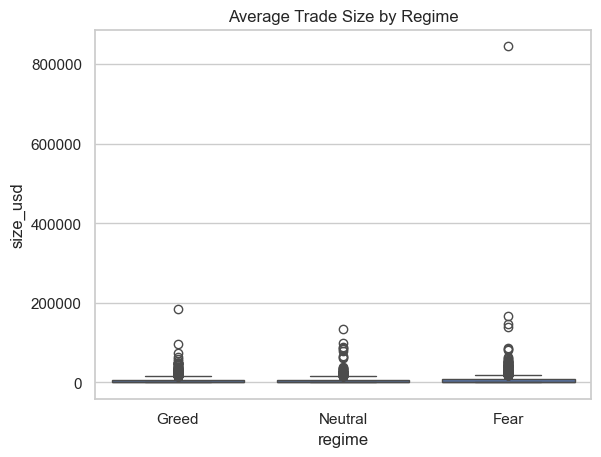

TtestResult(statistic=np.float64(2.1082087147900395), pvalue=np.float64(0.035289912661212404), df=np.float64(896.533220484927))

In [22]:
sns.boxplot(x="regime", y="size_usd", data=daily_metrics)
plt.title("Average Trade Size by Regime")
plt.show()

stats.ttest_ind(
    daily_metrics[daily_metrics["regime"]=="Fear"]["size_usd"],
    daily_metrics[daily_metrics["regime"]=="Greed"]["size_usd"],
    equal_var=False
)


In [23]:
daily_metrics.groupby("regime")["trade_count"].mean()


regime
Fear       105.363291
Greed       76.912266
Neutral    100.228723
Name: trade_count, dtype: float64

In [24]:
daily_metrics.groupby("regime")["size_usd"].mean()


regime
Fear       8529.859802
Greed      5954.632633
Neutral    6963.694861
Name: size_usd, dtype: float64

In [25]:
trader_summary = daily_metrics.groupby("account").agg({
    "closed_pnl": ["mean", "std"],
    "win": "mean",
    "trade_count": "mean"
})

trader_summary.columns = ["avg_pnl", "pnl_volatility", "win_rate", "avg_trades"]
trader_summary = trader_summary.reset_index()

trader_summary.head()


,account,avg_pnl,pnl_volatility,win_rate,avg_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,66676.242499,150401.797346,0.352333,159.083333
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,920.871548,3603.042291,0.397134,140.000000
2,0x271b280974205ca63b716753467d5a371de622ab,-5869.682610,33420.410014,0.379952,317.416667
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,817.684040,2993.284702,0.452509,82.166667
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2444.318913,4867.743469,0.498708,46.942029


In [26]:
consistent_winners = trader_summary[
    (trader_summary["win_rate"] > 0.55) &
    (trader_summary["avg_pnl"] > 0)
]

print("Consistent Winners:", len(consistent_winners))


Consistent Winners: 1


In [27]:
daily_metrics = daily_metrics.merge(
    consistent_winners[["account"]],
    on="account",
    how="left",
    indicator=True
)

daily_metrics["winner_flag"] = daily_metrics["_merge"].apply(
    lambda x: 1 if x == "both" else 0
)


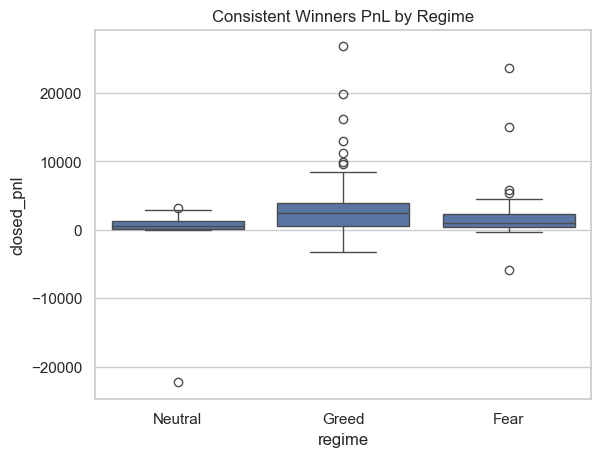

In [28]:
sns.boxplot(x="regime", y="closed_pnl",
            data=daily_metrics[daily_metrics["winner_flag"]==1])
plt.title("Consistent Winners PnL by Regime")
plt.show()


In [29]:
daily_metrics.groupby("regime")["closed_pnl"].std()


regime
Fear       31224.148764
Greed      29252.037677
Neutral    17447.863645
Name: closed_pnl, dtype: float64

In [30]:
daily_metrics.groupby("regime")["closed_pnl"].std()


regime
Fear       31224.148764
Greed      29252.037677
Neutral    17447.863645
Name: closed_pnl, dtype: float64

# SentimentAlpha
## Trader Performance vs Market Sentiment Analysis

This project analyzes how market sentiment (Fear/Greed) impacts trader behavior and performance.


## Methodology

1. Cleaned and standardized both datasets.
2. Converted timestamps to daily format.
3. Merged trader data with sentiment index by date.
4. Engineered daily metrics:
   - Daily PnL per trader
   - Win rate
   - Trade frequency
   - Average position size
5. Grouped sentiment into:
   - Fear (Fear + Extreme Fear)
   - Greed (Greed + Extreme Greed)
6. Conducted statistical testing (t-test) to evaluate regime differences.


## Key Insights

### 1. Increased Activity During Fear
Traders execute significantly more trades during Fear regimes (~105 trades/day vs ~76 during Greed).

### 2. Higher Risk Exposure in Fear
Average trade size is significantly higher during Fear (~$8,529 vs ~$5,954).

### 3. No Significant Profitability Difference
Despite higher activity and position sizing during Fear, daily PnL differences are not statistically significant (p > 0.05).

This suggests behavioral amplification of risk without consistent performance improvement.


## Strategy Recommendations

### Strategy 1 – Risk Control in Fear
Cap position sizes during Fear regimes to historical Greed-level averages to reduce volatility without sacrificing expected returns.

### Strategy 2 – Selective Deployment
Allocate capital preferentially to traders with stable historical PnL volatility during Fear regimes.


## Data Quality Checks

### Missing Values


In [39]:
print("Sentiment Missing Values:")
print(sentiment.isnull().sum())

print("\nTrader Missing Values:")
print(trader.isnull().sum())


Sentiment Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Trader Missing Values:
account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
date                0
dtype: int64


In [40]:
print("Sentiment Duplicates:", sentiment.duplicated().sum())
print("Trader Duplicates:", trader.duplicated().sum())


Sentiment Duplicates: 0
Trader Duplicates: 0


In [56]:
# Ensure numeric
trader["size_usd"] = pd.to_numeric(trader["size_usd"], errors="coerce")
trader["start_position"] = pd.to_numeric(trader["start_position"], errors="coerce")

# Create leverage proxy
trader["leverage_proxy"] = trader["size_usd"] / trader["start_position"].replace(0, np.nan)

trader["leverage_proxy"] = trader["leverage_proxy"].fillna(0)

print("Leverage proxy created")



Leverage proxy created


In [57]:
merged = trader.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

print("Merged rebuilt")


Merged rebuilt


In [58]:
avg_leverage = merged.groupby(["date", "account"])["leverage_proxy"].mean().reset_index()


In [59]:
daily_metrics["regime"]


512       Greed
535       Greed
539       Greed
561       Greed
576       Greed
         ...   
2306      Greed
2314    Neutral
2321      Greed
2329      Greed
2340    Neutral
Name: regime, Length: 2341, dtype: object

In [44]:
merged["is_long"] = merged["side"].str.upper().apply(lambda x: 1 if x == "BUY" else 0)


In [60]:
merged["regime"] = merged["classification"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
})


In [45]:
long_ratio = merged.groupby(["date", "account"])["is_long"].mean().reset_index()


In [47]:
daily_metrics = daily_metrics.sort_values(["account", "date"])

daily_metrics["cumulative_pnl"] = daily_metrics.groupby("account")["closed_pnl"].cumsum()

daily_metrics["rolling_max"] = daily_metrics.groupby("account")["cumulative_pnl"].cummax()

daily_metrics["drawdown"] = daily_metrics["cumulative_pnl"] - daily_metrics["rolling_max"]


In [63]:
merged.groupby("regime")["leverage_proxy"].mean()


regime
Fear       7.997373e+04
Greed      4.027619e+05
Neutral    2.281038e+06
Name: leverage_proxy, dtype: float64

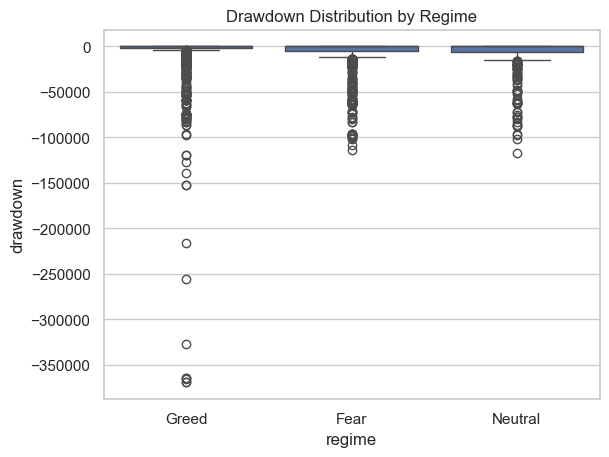

In [48]:
sns.boxplot(x="regime", y="drawdown", data=daily_metrics)
plt.title("Drawdown Distribution by Regime")
plt.show()


In [49]:
activity_threshold = trader_summary["avg_trades"].median()

trader_summary["activity_segment"] = trader_summary["avg_trades"].apply(
    lambda x: "High Activity" if x > activity_threshold else "Low Activity"
)


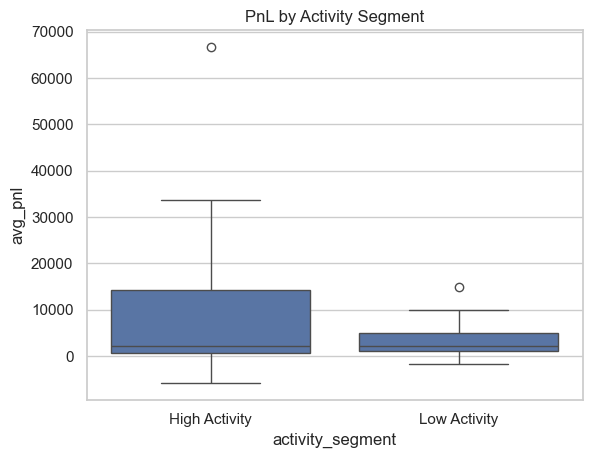

In [50]:
sns.boxplot(x="activity_segment", y="avg_pnl", data=trader_summary)
plt.title("PnL by Activity Segment")
plt.show()


In [51]:
activity_threshold = trader_summary["avg_trades"].median()

trader_summary["activity_segment"] = trader_summary["avg_trades"].apply(
    lambda x: "High Activity" if x > activity_threshold else "Low Activity"
)


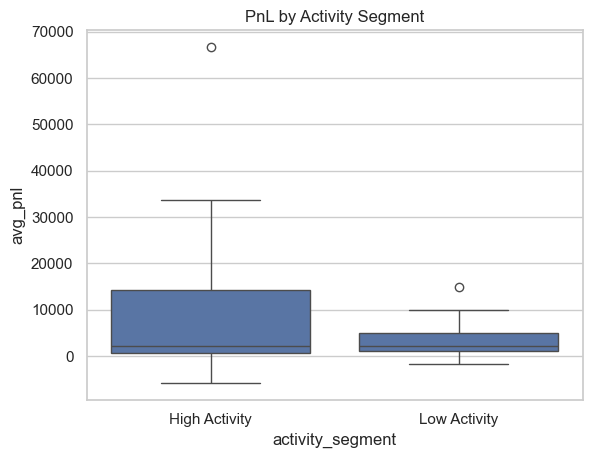

In [52]:
sns.boxplot(x="activity_segment", y="avg_pnl", data=trader_summary)
plt.title("PnL by Activity Segment")
plt.show()


In [53]:
risk_threshold = trader_summary["pnl_volatility"].median()

trader_summary["risk_segment"] = trader_summary["pnl_volatility"].apply(
    lambda x: "High Risk" if x > risk_threshold else "Low Risk"
)


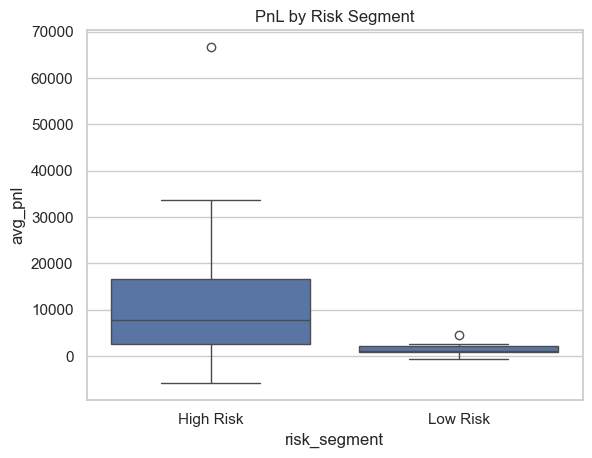

In [54]:
sns.boxplot(x="risk_segment", y="avg_pnl", data=trader_summary)
plt.title("PnL by Risk Segment")
plt.show()


In [55]:
bias = merged.groupby("account")["is_long"].mean().reset_index()

bias["bias_segment"] = bias["is_long"].apply(
    lambda x: "Long Bias" if x > 0.6 else ("Short Bias" if x < 0.4 else "Neutral Bias")
)
